In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
import imutils
from imutils import paths
import os
import os.path

## Extracting letters from each captcha for training the model

In [2]:
SOLVED_CAPTCHA_FOLDER = "solved-captchas"
OUTPUT_FOLDER = "extracted_letters"


# Get the path of all the solved captcha images
solved_captchas = glob.glob(os.path.join(SOLVED_CAPTCHA_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha) in enumerate(solved_captchas):
    print("processing image {}/{}".format(i + 1, len(solved_captchas)))

    
    # grab the base filename as the text
    filename = os.path.basename(captcha)
    captcha_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # applying threshold
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

     # finding the contours
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creating empty list for holding the coordinates of the letters
    letter_image_regions = []

    # Now we will loop through each of the contours and extract the letter
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # checking if any counter is too wide
        # if countour is too wide then there could be two letters joined together or are very close to each other
        if w / h > 1.25:
            # Split it in half into two letter regions
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            
            letter_image_regions.append((x, y, w, h))
            

    
    # Sort the detected letter images based on the x coordinate to make sure
    # we get them from left-to-right so that we match the right image with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Save each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]


        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # creating different output folder for storing different letters
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count)))
        cv2.imwrite(p, letter_image)

        # increment the count
        counts[letter_text] = count + 1


processing image 1/939
processing image 2/939
processing image 3/939
processing image 4/939
processing image 5/939
processing image 6/939
processing image 7/939
processing image 8/939
processing image 9/939
processing image 10/939
processing image 11/939
processing image 12/939
processing image 13/939
processing image 14/939
processing image 15/939
processing image 16/939
processing image 17/939
processing image 18/939
processing image 19/939
processing image 20/939
processing image 21/939
processing image 22/939
processing image 23/939
processing image 24/939
processing image 25/939
processing image 26/939
processing image 27/939
processing image 28/939
processing image 29/939
processing image 30/939
processing image 31/939
processing image 32/939
processing image 33/939
processing image 34/939
processing image 35/939
processing image 36/939
processing image 37/939
processing image 38/939
processing image 39/939
processing image 40/939
processing image 41/939
processing image 42/939
p

processing image 360/939
processing image 361/939
processing image 362/939
processing image 363/939
processing image 364/939
processing image 365/939
processing image 366/939
processing image 367/939
processing image 368/939
processing image 369/939
processing image 370/939
processing image 371/939
processing image 372/939
processing image 373/939
processing image 374/939
processing image 375/939
processing image 376/939
processing image 377/939
processing image 378/939
processing image 379/939
processing image 380/939
processing image 381/939
processing image 382/939
processing image 383/939
processing image 384/939
processing image 385/939
processing image 386/939
processing image 387/939
processing image 388/939
processing image 389/939
processing image 390/939
processing image 391/939
processing image 392/939
processing image 393/939
processing image 394/939
processing image 395/939
processing image 396/939
processing image 397/939
processing image 398/939
processing image 399/939


processing image 736/939
processing image 737/939
processing image 738/939
processing image 739/939
processing image 740/939
processing image 741/939
processing image 742/939
processing image 743/939
processing image 744/939
processing image 745/939
processing image 746/939
processing image 747/939
processing image 748/939
processing image 749/939
processing image 750/939
processing image 751/939
processing image 752/939
processing image 753/939
processing image 754/939
processing image 755/939
processing image 756/939
processing image 757/939
processing image 758/939
processing image 759/939
processing image 760/939
processing image 761/939
processing image 762/939
processing image 763/939
processing image 764/939
processing image 765/939
processing image 766/939
processing image 767/939
processing image 768/939
processing image 769/939
processing image 770/939
processing image 771/939
processing image 772/939
processing image 773/939
processing image 774/939
processing image 775/939


## Preparing training data

In [3]:
letter_folder = 'extracted_letters'

#creating empty lists for storing image data and labels
data = []
labels = []
for image in paths.list_images(letter_folder):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (30,30))
    
    # adding a 3rd dimension to the image
    img = np.expand_dims(img, axis = 2)
    
    #grabing the name of the letter based on the folder it is present in
    label = image.split(os.path.sep)[-2]
    
    # appending to the empty lists
    data.append(img)
    labels.append(label)

#converting data and labels to np array
data = np.array(data, dtype = "float")
labels = np.array(labels)

print(data.shape, labels.shape)
    

(4695, 30, 30, 1) (4695,)


In [4]:
#scaling the values of  data between 0 and 1
data = data/255.0

In [5]:
# Split the training data into separate train and test sets
from sklearn.model_selection import train_test_split
(train_x, val_x, train_y, val_y) = train_test_split(data, labels, test_size=0.2, random_state=0)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(3756, 30, 30, 1) (939, 30, 30, 1) (3756,) (939,)


In [8]:
# one hot encoding our target variable 'labels'
from sklearn.preprocessing import LabelBinarizer
import pickle
lb = LabelBinarizer().fit(train_y)
train_y = lb.transform(train_y)
val_y = lb.transform(val_y)

bin = pickle.dumps(lb)
with open("captcha_labels.pickle", "wb") as f:
    pickle.dump(lb, f)

print(train_y.shape, val_y.shape)

(3756, 9) (939, 9)


In [7]:
bin

b'\x80\x03csklearn.preprocessing.label\nLabelBinarizer\nq\x00)\x81q\x01}q\x02(X\t\x00\x00\x00neg_labelq\x03K\x00X\t\x00\x00\x00pos_labelq\x04K\x01X\r\x00\x00\x00sparse_outputq\x05\x89X\x07\x00\x00\x00y_type_q\x06X\n\x00\x00\x00multiclassq\x07X\r\x00\x00\x00sparse_input_q\x08\x89X\x08\x00\x00\x00classes_q\tcnumpy.core.multiarray\n_reconstruct\nq\ncnumpy\nndarray\nq\x0bK\x00\x85q\x0cC\x01bq\r\x87q\x0eRq\x0f(K\x01K\t\x85q\x10cnumpy\ndtype\nq\x11X\x02\x00\x00\x00U1q\x12K\x00K\x01\x87q\x13Rq\x14(K\x03X\x01\x00\x00\x00<q\x15NNNK\x04K\x04K\x08tq\x16b\x89C$1\x00\x00\x002\x00\x00\x003\x00\x00\x004\x00\x00\x005\x00\x00\x006\x00\x00\x007\x00\x00\x008\x00\x00\x009\x00\x00\x00q\x17tq\x18bX\x10\x00\x00\x00_sklearn_versionq\x19X\x06\x00\x00\x000.20.2q\x1aub.'

## Model Building

In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [8]:
model = Sequential()
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(30, 30, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(9, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               313728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [9]:
# using early stoping for avoiding overfitting
estop = EarlyStopping(patience=10, mode='min', min_delta=0.001, monitor='val_loss')

In [10]:
model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=32, epochs=50, verbose=1, callbacks = [estop])

Train on 3756 samples, validate on 939 samples
Epoch 1/50
3756/3756 [==============================] - 18s 5ms/step - loss: 0.3291 - acc: 0.9156 - val_loss: 0.0437 - val_acc: 0.9968
Epoch 2/50
3756/3756 [==============================] - 2s 508us/step - loss: 0.0200 - acc: 0.9984 - val_loss: 0.0428 - val_acc: 0.9968
Epoch 3/50
3756/3756 [==============================] - 2s 577us/step - loss: 0.0194 - acc: 0.9987 - val_loss: 0.0468 - val_acc: 0.9968
Epoch 4/50
3756/3756 [==============================] - 2s 531us/step - loss: 0.0211 - acc: 0.9984 - val_loss: 0.0387 - val_acc: 0.9968
Epoch 5/50
3756/3756 [==============================] - 2s 553us/step - loss: 0.0196 - acc: 0.9984 - val_loss: 0.0437 - val_acc: 0.9968
Epoch 6/50
3756/3756 [==============================] - 2s 530us/step - loss: 0.0180 - acc: 0.9987 - val_loss: 0.0441 - val_acc: 0.9968
Epoch 7/50
3756/3756 [==============================] - 2s 494us/step - loss: 0.0185 - acc: 0.9984 - val_loss: 0.0490 - val_acc: 0.9968
Ep

### Testing model on an unseen captcha

CAPTCHA text is: 66372


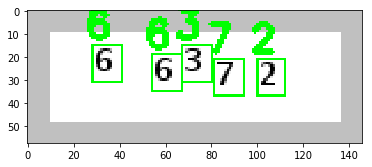

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# Load the image and convert it to grayscale
image = cv2.imread('./unsolved-captchas/0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

# find the contours
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    
letter_image_regions = []

# Now we can loop through each of the contours and extract the letter

for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    
    # checking if any counter is too wide
    # if countour is too wide then there could be two letters joined together or are very close to each other
    if w / h > 1.25:
        # Split it in half into two letter regions
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        letter_image_regions.append((x, y, w, h))
            

# Sort the detected letter images based on the x coordinate to make sure
# we get them from left-to-right so that we match the right image with the right letter  

letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3)
predictions = []
    
# Creating an empty list for storing predicted letters
predictions = []
    
# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    letter_image = cv2.resize(letter_image, (30,30))
        
    # Turn the single image into a 4d list of images
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)

    # making prediction
    pred = model.predict(letter_image)
        
    # Convert the one-hot-encoded prediction back to a normal letter
    letter = lb.inverse_transform(pred)[0]
    predictions.append(letter)


    # draw the prediction on the output image
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
    cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)

In [13]:
#Saving the model for future use
model.save("captcha_extractor_model.hdf5")

### Making predictions on test data

In [ ]:
test_image_folder = 'unsolved-captchas'
OUTPUT_FOLDER = 'predicted captchas'
test_captcha_images = glob.glob(os.path.join(test_image_folder, "*"))

In [ ]:
# loop over the image paths
for (i, image) in enumerate(test_captcha_images):
    print("processing image {}/{}".format(i + 1, len(test_captcha_images)))

    # Load the image and convert it to grayscale
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    letter_image_regions = []

    # Now we can loop through each of the contours and extract the letter
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # checking if any counter is too wide
        # if countour is too wide then there could be two letters joined together or are very close to each other
        if w / h > 1.25:
            # Split it in half into two letter regions
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
            

    
    # Sort the detected letter images based on the x coordinate to make sure
    # we get them from left-to-right so that we match the right image with the right letter  
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Creating an empty list for storing predicted letters
    predictions = []
    
    # Save out each letter as a single image
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        letter_image = cv2.resize(letter_image, (30,30))
        
        # Turn the single image into a 4d list of images
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # making prediction
        pred = model.predict(letter_image)
        
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(pred)[0]
        predictions.append(letter)

        
    # joining predicted captcha's text
    captcha_text = "".join(predictions)
    
    # Get the folder to save the image in
    save_path = os.path.join(OUTPUT_FOLDER, captcha_text)
    
    p = os.path.join(save_path+'.png' )
    #writing the image to the output folder
    cv2.imwrite(p, img)
